<h1>Desarrollo de Aplicaciones para el Análisis de Datos</h1>

<h2>Proyecto final: Predicción de aprobación de tarjetas de crédito</h2>

* Pineda Hernández Francisco
* Ramírez Aguilar Rodrigo Vidal

## Carga de Datos

Importar las librerías necesarias para la manipulación, análisis de datos, gráficación y modelos de clasificación.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Lectura del Dataset por medio de Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
rutaDrive = "/content/drive/My Drive/Datasets/"

Mounted at /content/drive


In [ ]:
archivo1 = "credit_record.csv"
rutaCompleta1 = os.path.join(rutaDrive, archivo1)

In [ ]:
archivo2 = "application_record.csv"
rutaCompleta2 = os.path.join(rutaDrive, archivo2)

In [ ]:
creditos = pd.read_csv(rutaCompleta1)
aplicantes = pd.read_csv(rutaCompleta2)

## Informacion proporcionada en el Dataset

El atributo MONTHS_BALANCE se tiene la siguiente organización: <br>
El mes de los datos extraídos es el punto de partida. Hacia atrás: 0 es el mes actual; -1 es el mes anterior, y así sucesivamente.

Para STATUS se tiene:
* 0: 1-29 días de retraso
* 1: 30-59 días de retraso
* 2: 60-89 días de retraso
* 3: 90-119 días de retraso
* 4: 120-149 días de retraso
* 5: Deudas vencidas o incobrables, canceladas durante más de 150 días
* C: saldado ese mes
* X: Sin préstamo ese mes

## Análisis Exploratorio de Datos

In [ ]:
aplicantes.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [ ]:
creditos.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [ ]:
aplicantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [ ]:
creditos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [ ]:
aplicantes.shape

(438557, 18)

In [ ]:
creditos.shape

(1048575, 3)

Analizamos la proporción de las categorías del Dataset **Conteo**

<ipython-input-12-10267a61aa85>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo.index, y=conteo.values, palette="muted")


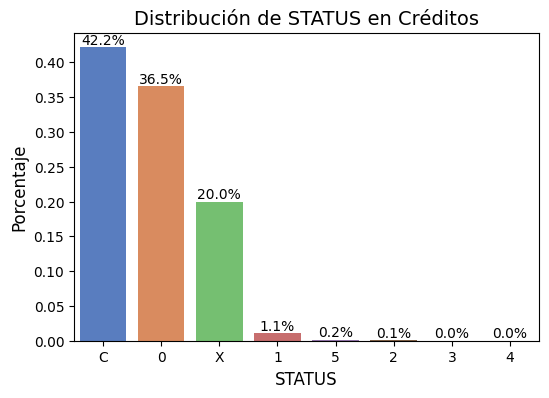

In [ ]:
conteo = creditos['STATUS'].value_counts() / creditos.shape[0]

plt.figure(figsize=(6,4))
sns.barplot(x=conteo.index, y=conteo.values, palette="muted")

plt.title('Distribución de STATUS en Créditos', fontsize=14)
plt.xlabel('STATUS', fontsize=12)
plt.ylabel('Porcentaje', fontsize=12)

# Mostrar los porcentajes encima de las barras
for i, value in enumerate(conteo.values):
    plt.text(i, value, f'{value:.1%}', ha='center', va='bottom', fontsize=10)

plt.show()

Podemos apreciar un claro desbalance en las clases con los valores numéricos del 1 al 5, los cuales se tratarán más adelante durante la limpieza de datos.

## Limpieza de Datos

In [ ]:
def desbalanceClases(atributo):
  conteos = atributo.value_counts()
  max_clase = conteos.idxmax()
  min_clase = conteos.idxmin()
  desbalance = conteos.max() / conteos.min()
  return max_clase, min_clase, desbalance


In [ ]:
df_desbalance = pd.DataFrame(columns=['Atributo', 'Max', 'Min', 'Desbalance'])
for column in aplicantes.columns:
  max, min, desbalance = desbalanceClases(aplicantes[column])
  df_desbalance.loc[len(df_desbalance)] = (column, max, min, desbalance)

df_desbalance

,Atributo,Max,Min,Desbalance
0,ID,7137299,6147693,2.000000
1,CODE_GENDER,F,M,2.043062
2,FLAG_OWN_CAR,N,Y,1.688917
3,FLAG_OWN_REALTY,Y,N,2.261059
4,CNT_CHILDREN,0,19,304071.000000
5,AMT_INCOME_TOTAL,135000.0,187497.0,46879.000000
6,NAME_INCOME_TYPE,Working,Student,13300.235294
7,NAME_EDUCATION_TYPE,Secondary / secondary special,Academic degree,967.375000
8,NAME_FAMILY_STATUS,Married,Widow,15.239034
9,NAME_HOUSING_TYPE,House / apartment,Co-op apartment,255.900585


Observamos un gran desbalance de clases en la mayoría de las categorías, por lo que se tendrán que tomar acciones posteriores al respecto.

In [ ]:
# Copiamos el dataset original para poder hacerle modificaciones de forma
# segura durante la limpieza
creditos_clean = creditos.copy()

Añadimos una nueva columna biclase donde categorizamos segun el STATUS si un ID es "Bueno" o "Malo" en el contexto créditicio.

In [ ]:
creditos_clean['Bueno o Malo'] = ['Bueno' if x in set(['0','C', 'X']) else 'Malo' for x in creditos_clean['STATUS']]
creditos_clean.head()

,ID,MONTHS_BALANCE,STATUS,Bueno o Malo
0,5001711,0,X,Bueno
1,5001711,-1,0,Bueno
2,5001711,-2,0,Bueno
3,5001711,-3,0,Bueno
4,5001712,0,C,Bueno


Contamos agrupando por ID, que tantas veces es considerado "Bueno" o "Malo"

In [ ]:
creditos_clean = creditos_clean.groupby(['ID','Bueno o Malo']).size().to_frame('size')
creditos_clean.reset_index(inplace=True)
creditos_clean.head()

,ID,Bueno o Malo,size
0,5001711,Bueno,4
1,5001712,Bueno,19
2,5001713,Bueno,22
3,5001714,Bueno,15
4,5001715,Bueno,60


Observamos un desbalance en las categorías que definimos.

In [ ]:
creditos_clean['Bueno o Malo'].value_counts()

,count
Bueno o Malo,
Bueno,45984
Malo,5350


Verificamos por cliente, que tantos registros existen de sus datos "Buenos" y "Malos" para posteriormente categorizarlo.

In [ ]:
idx = creditos_clean.groupby('ID')['size'].idxmax()
creditos_clean = creditos_clean.loc[idx]
creditos_clean

,ID,Bueno o Malo,size
0,5001711,Bueno,4
1,5001712,Bueno,19
2,5001713,Bueno,22
3,5001714,Bueno,15
4,5001715,Bueno,60
...,...,...,...
51329,5150482,Bueno,18
51330,5150483,Bueno,18
51331,5150484,Bueno,13
51332,5150485,Bueno,2


### Añadir la columna 'Label'
Label actuará como nuestro Target o variable objetivo al momento de realizar la clasificación.

In [ ]:
creditos_clean['Label'] = [
    1 if etiqueta == 'Bueno' and 0 < valor < 20 else
    2 if etiqueta == 'Bueno' and 20 <= valor < 40 else
    3 if etiqueta == 'Bueno' and 40 <= valor else 0
    for valor, etiqueta in zip(creditos_clean['size'], creditos_clean['Bueno o Malo'])
]
creditos_clean

,ID,Bueno o Malo,size,Label
0,5001711,Bueno,4,1
1,5001712,Bueno,19,1
2,5001713,Bueno,22,2
3,5001714,Bueno,15,1
4,5001715,Bueno,60,3
...,...,...,...,...
51329,5150482,Bueno,18,1
51330,5150483,Bueno,18,1
51331,5150484,Bueno,13,1
51332,5150485,Bueno,2,1


Eliminamos la columnas innecesarías ya que contamos con nuestro target.

In [ ]:
creditos_clean = creditos_clean.drop(['Bueno o Malo', 'size'], axis=1)
creditos_clean = creditos_clean.reset_index(drop=True)
creditos_clean

,ID,Label
0,5001711,1
1,5001712,1
2,5001713,2
3,5001714,1
4,5001715,3
...,...,...
45980,5150482,1
45981,5150483,1
45982,5150484,1
45983,5150485,1


Analizamos la proporción de las categorías en Label del Dataset **Conteo**

<ipython-input-22-d5e2711b0f61>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_label.index, y=conteo_label.values, palette="muted")


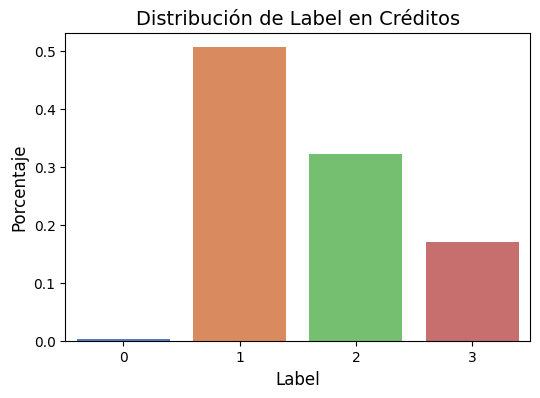

In [ ]:
conteo_label = creditos_clean['Label'].value_counts() / creditos_clean.shape[0]

plt.figure(figsize=(6,4))
sns.barplot(x=conteo_label.index, y=conteo_label.values, palette="muted")

plt.title('Distribución de Label en Créditos', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Porcentaje', fontsize=12)

plt.show()

Como podemos observar, existe un desbalance muy grande para la categoría de 0.

### Merge para obtener el Dataframe final con el que se trabajará

In [ ]:
data = pd.merge(aplicantes, creditos_clean, how='inner', on='ID')
data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Label
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,2
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,1


Realizamos una copia del dataframe final para poder manipularlo sin comprometer los datos y agilizar el uso del mismo.

In [ ]:
data2 = data.copy()

In [ ]:
data2.shape

(36457, 19)

## Valores perdidos

Observamos una gran cantidad de valores faltantes en la columna **OCCUPATION_TYPE**, por lo que realizaremos una imputación por medio de un modelo de **Random Forest** ya que esta es una variable imporante que necesitaremos en nuestros experimentos finales.

In [ ]:
data2['OCCUPATION_TYPE'].isnull().sum()

11323

### Imputación a OCCUPATION_TYPE

Creamos una copia del Dataframe para poder verificar la diferencia con los valores imputados.

In [ ]:
data3 = data2.copy()

In [ ]:
# Librerías necesarias para utilizar RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Separar los datos con valores conocidos y desconocidos en OCCUPATION_TYPE
known_occupation = data3[data3['OCCUPATION_TYPE'].notna()]
unknown_occupation = data3[data3['OCCUPATION_TYPE'].isna()]

# Seleccionar columnas relevantes para predecir OCCUPATION_TYPE
features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
            'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
            'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'Label']

# Convertir las variables categóricas a numéricas con one-hot encoding
data_encoded = pd.get_dummies(data3, columns=features, drop_first=True)

# Volver a dividir en datos conocidos y desconocidos después de codificar
known_occupation = data_encoded[data_encoded['OCCUPATION_TYPE'].notna()]
unknown_occupation = data_encoded[data_encoded['OCCUPATION_TYPE'].isna()]

# Preparar los datos para el modelo
X_known = known_occupation.drop('OCCUPATION_TYPE', axis=1)
y_known = known_occupation['OCCUPATION_TYPE']
X_unknown = unknown_occupation.drop('OCCUPATION_TYPE', axis=1)

# Dividir los datos conocidos en entrenamiento y prueba
X_train_oc, X_test_oc, y_train_oc, y_test_oc = train_test_split(X_known, y_known, test_size=0.2, random_state=42)

# Entrenar un modelo de Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train_oc, y_train_oc)

# Validar el modelo
y_pred = model.predict(X_test_oc)
accuracy = accuracy_score(y_test_oc, y_pred)
print(f'Exactitud del modelo: {accuracy:.2f}')

# Predecir los valores faltantes
predicted_occupation = model.predict(X_unknown)

# Rellenar los valores faltantes en el dataset original
data3.loc[data3['OCCUPATION_TYPE'].isna(), 'OCCUPATION_TYPE'] = predicted_occupation


Exactitud del modelo: 0.93


Una vez que obtenemos el Dataframe con los valores de Ocupación imputados con una precisión de 93%, procedemos a hacer una nueva copia para seguir trabajando con el dataframe.

In [ ]:
data4 = data3.copy()

Verificamos el Dataframe obtenido.

In [ ]:
data4.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Label
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Managers,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Managers,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,2
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1


Observamos que son correctas las imputaciones.

Verificamos la cantidad de valores nulos.

In [ ]:
data4.isnull().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
Label                  0
dtype: int64

Observamos la diferencia entre el dataset original y el obtenido tras las imputaciones para verificar que las proporciones imputadas sean realistas conforme a los valores originales.

In [ ]:
diferencias = pd.DataFrame(columns=['Ocupacion', 'Diferencia'])
for occupation in data4['OCCUPATION_TYPE'].unique():
  diferencias.loc[len(diferencias)] = (occupation, data4[data4['OCCUPATION_TYPE'] == occupation].shape[0] - data2[data2['OCCUPATION_TYPE'] == occupation].shape[0])

diferencias

,Ocupacion,Diferencia
0,Managers,1222
1,Security staff,7
2,Sales staff,3210
3,Core staff,1232
4,Accountants,210
5,Laborers,4961
6,Drivers,204
7,High skill tech staff,38
8,Cleaning staff,39
9,Private service staff,50


### Codificación de Variables Categóricas a Numéricas

Procedemos a encontrar las columnas no numéricas del Dataset para transformarlas y poder utilizarlas posteriormente con los modelos.

In [ ]:
columnas_no_numericas = data4.select_dtypes(exclude=['number']).columns
columnas_no_numericas

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE'],
      dtype='object')

In [ ]:
data4[columnas_no_numericas].head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE
0,M,Y,Y,Working,Higher education,Civil marriage,Rented apartment,Managers
1,M,Y,Y,Working,Higher education,Civil marriage,Rented apartment,Managers
2,M,Y,Y,Working,Secondary / secondary special,Married,House / apartment,Security staff
3,F,N,Y,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff
4,F,N,Y,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff


Realizamos la conversión de aquellas que son binarias.

In [ ]:
data4['CODE_GENDER'] = data4['CODE_GENDER'].map({'F':1, 'M':0})
data4['FLAG_OWN_CAR'] = data4['FLAG_OWN_CAR'].map({'Y':1, 'N':0})
data4['FLAG_OWN_REALTY'] = data4['FLAG_OWN_REALTY'].map({'Y':1, 'N':0})
data4[columnas_no_numericas].head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE
0,0,1,1,Working,Higher education,Civil marriage,Rented apartment,Managers
1,0,1,1,Working,Higher education,Civil marriage,Rented apartment,Managers
2,0,1,1,Working,Secondary / secondary special,Married,House / apartment,Security staff
3,1,0,1,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff
4,1,0,1,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff


Analizamos las proporciones de cada categoría restante, vemos que no son binarias.

In [ ]:
for column in columnas_no_numericas[3:]:
  print(data4[column].value_counts(), '\n')

NAME_INCOME_TYPE
Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: count, dtype: int64 

NAME_EDUCATION_TYPE
Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: count, dtype: int64 

NAME_FAMILY_STATUS
Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: count, dtype: int64 

NAME_HOUSING_TYPE
House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: count, dtype: int64 

OCCUPATION_TYPE
Laborers                 11172
Sales staff               6695
Core staff                4823
Managers                  4234
Drive

Realizamos la conversión de las columnas restantes, asignando un número desde 0 hasta sus respectivas N categorías de forma discreta.

In [ ]:
mapeos = {}

# Iterar sobre cada columna categórica
for columna in data4.select_dtypes(include=['object']).columns:
    # Obtener las categorías únicas de la columna
    categorias = data4[columna].unique()
    # Crear un diccionario de mapeo
    mapeo = {categoria: i+1 for i, categoria in enumerate(categorias)}
    mapeos[columna] = mapeo
    # Reemplazar las categorías por números
    data4[columna] = data4[columna].map(mapeo)

data4.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Label
0,5008804,0,1,1,0,427500.0,1,1,1,1,-12005,-4542,1,1,0,0,1,2.0,1
1,5008805,0,1,1,0,427500.0,1,1,1,1,-12005,-4542,1,1,0,0,1,2.0,1
2,5008806,0,1,1,0,112500.0,1,2,2,2,-21474,-1134,1,0,0,0,2,2.0,2
3,5008808,1,0,1,0,270000.0,2,2,3,2,-19110,-3051,1,0,1,1,3,1.0,1
4,5008809,1,0,1,0,270000.0,2,2,3,2,-19110,-3051,1,0,1,1,3,1.0,1


## Desbalance de clases

Comenzamos a tratar los desbalances de clases que fueron detectados durante la limpieza de datos.

Analizamos el inmenso desbalance para nuestra variable objetivo en su clase minoritaria.

C:\Users\ramir\AppData\Local\Temp\ipykernel_17716\2236363067.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo.index, y=conteo.values, palette="muted")


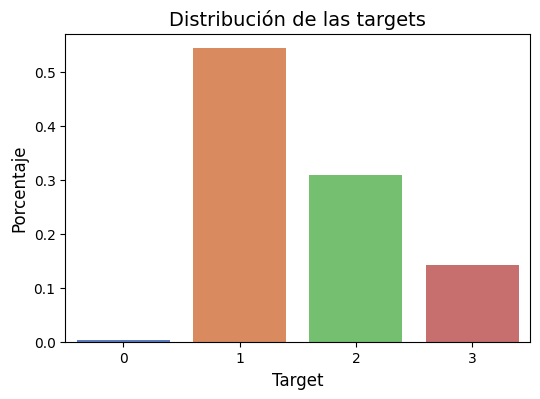

In [ ]:
conteo = data4['Label'].value_counts() / data4.shape[0]

plt.figure(figsize=(6,4))
sns.barplot(x=conteo.index, y=conteo.values, palette="muted")

plt.title('Distribución de las targets', fontsize=14)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Porcentaje', fontsize=12)

plt.show()

Procedemos a tratarlo creando un Dataframe unicamente con la clase minoritaria.

In [ ]:
datamin = data4[data4["Label"]==0]
datamin

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Label
2061,5021430,1,0,1,0,126000.0,2,1,3,2,-18907,-2470,1,0,0,0,3,1.0,0
2062,5021431,1,0,1,0,126000.0,2,1,3,2,-18907,-2470,1,0,0,0,3,1.0,0
4133,5024039,1,0,0,0,135000.0,1,2,2,2,-15459,-642,1,0,0,0,3,2.0,0
4270,5024213,1,1,1,0,540000.0,2,1,2,2,-15702,-185,1,0,1,0,1,2.0,0
4294,5024249,1,0,1,1,135000.0,2,2,2,2,-14099,-550,1,0,1,0,6,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36430,5143578,0,1,0,0,157500.0,1,3,3,4,-9124,-960,1,1,0,0,7,2.0,0
36432,5145690,1,0,1,0,306000.0,3,1,2,2,-21590,365243,1,0,0,0,1,2.0,0
36449,5149190,0,1,0,1,450000.0,1,1,2,2,-9847,-502,1,0,1,1,4,3.0,0
36453,5149834,1,0,1,0,157500.0,2,1,2,2,-12387,-1325,1,0,1,1,13,2.0,0


### Gráficas de la clase minoritaria 0

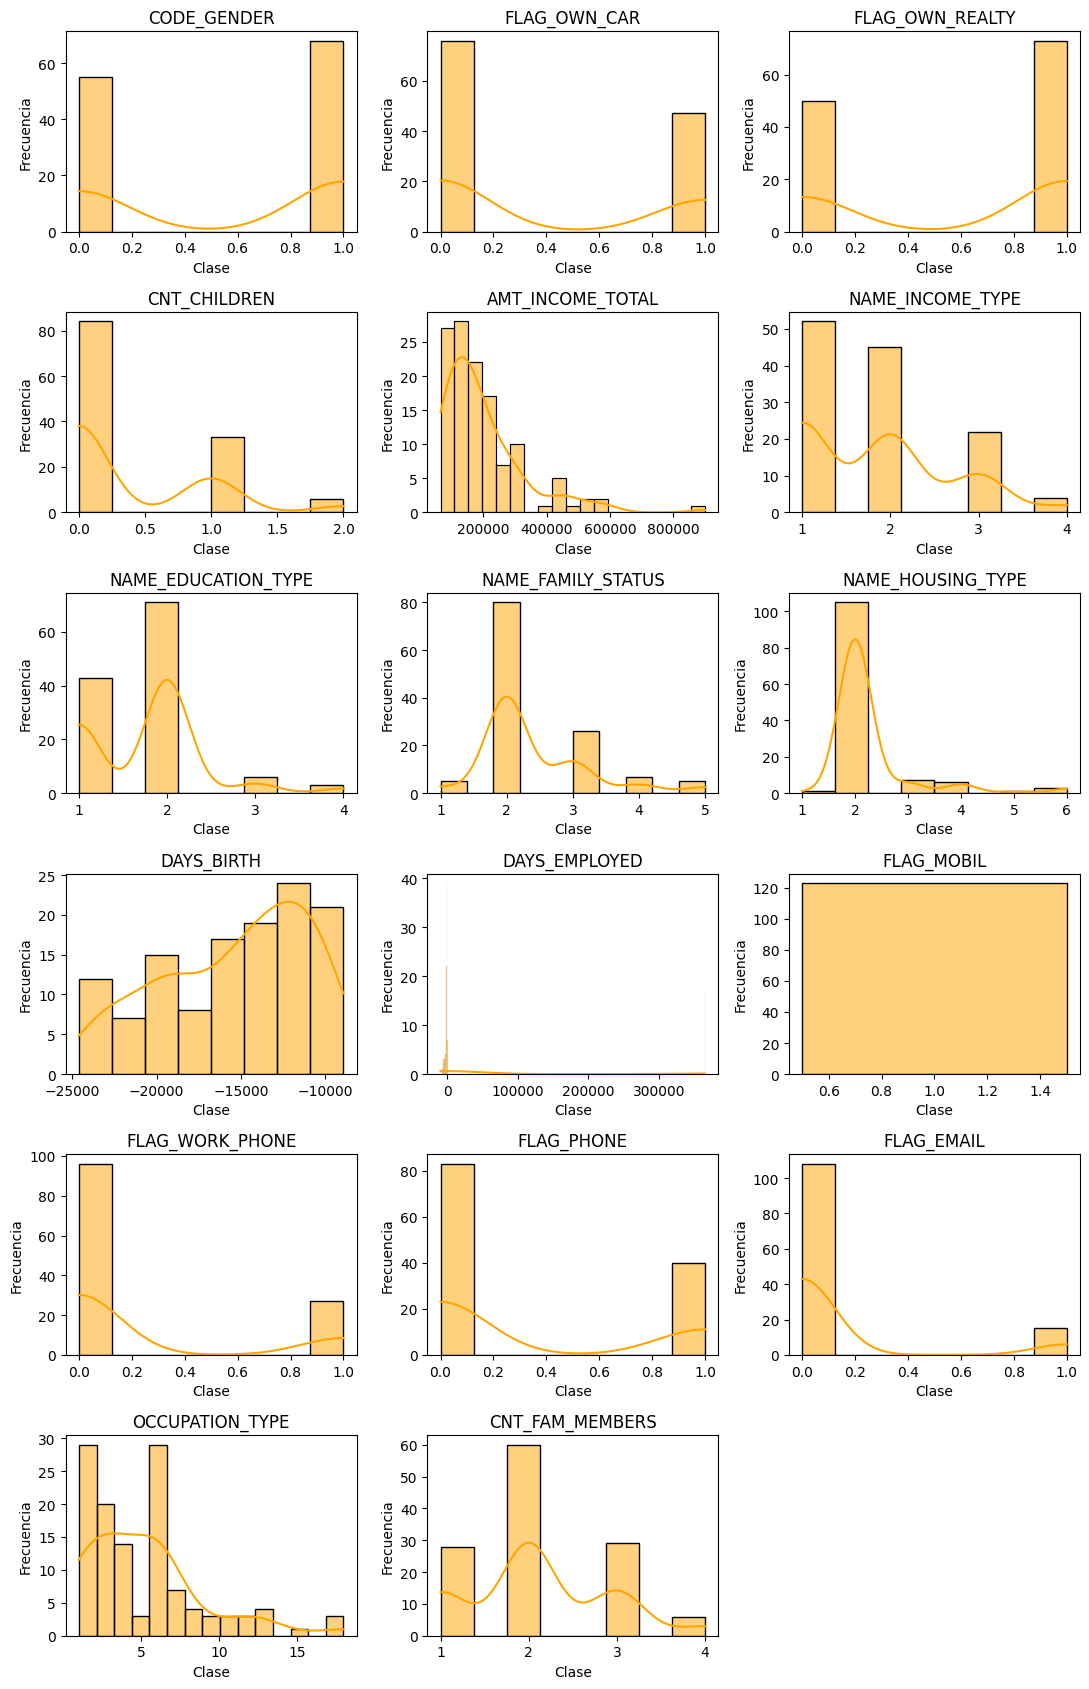

In [ ]:
# Lista de columnas a graficar (excluyendo 'ID' porque no tiene sentido para frecuencias)
columnas = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
            'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
            'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
            'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']

# Configuración de subplots (6 filas y 3 columnas)
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(11, 17))
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# Generar las gráficas
for i, col in enumerate(columnas):
    ax = axes[i]
    sns.histplot(datamin[col], kde=True, ax=ax, color="orange")
    ax.set_title(col)
    ax.set_xlabel('Clase')
    ax.set_ylabel('Frecuencia')

# Eliminar los ejes vacíos (si no hay 18 columnas)
for j in range(len(columnas), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Observamos que la poca cantidad de datos da muchos espacios vacíos en las gráficas, sin embargo, podemos apreciar las distribuciones de cada una, dandonos una clara idea de la forma en la que debemos imputar los datos.

Definimos una función que imputará 20,000 registros de ls dos ultimas clases minoritarias con sus respectivas distribuciones.

In [ ]:
def generate_synthetic_data(original_data, n_samples=13000):
    synthetic_data = pd.DataFrame()

    for column in original_data.columns:

        if column =="ID":
            last_id = original_data['ID'].max()
            new_ids = np.arange(last_id + 1, last_id + 1 + n_samples)
            synthetic_data[column] = new_ids
        elif original_data[column].nunique() < 10:
            synthetic_data[column] = np.random.choice(
                original_data[column].unique(),
                size=n_samples,
                p=original_data[column].value_counts(normalize=True).values
            )
        elif column =="OCCUPATION_TYPE":
            category_counts = original_data['OCCUPATION_TYPE'].value_counts()
            categories = category_counts.index
            probabilities = category_counts / category_counts.sum()

            synthetic_data['OCCUPATION_TYPE'] = np.random.choice(
                categories, size=n_samples, p=probabilities
            )
        else:
            mean = original_data[column].mean()
            std = original_data[column].std()
            min_val = original_data[column].min()
            #print(column,min_val)
            max_val = original_data[column].max()
            #print(column,max_val)

            if "DAYS" in column or column == "AMT_INCOME_TOTAL":
                min_val = original_data[column].min()
                shifted_data = original_data[column] - min_val + 1

                mean = shifted_data.mean()
                scale = 1 / mean if mean > 0 else 1

                synthetic_column = np.random.exponential(scale=scale, size=n_samples)

                synthetic_column = synthetic_column / synthetic_column.max() * (shifted_data.max() - shifted_data.min())

                synthetic_data[column] = synthetic_column + min_val - 1
                synthetic_data[column] = np.round(synthetic_data[column]).astype(int)

    return synthetic_data

Creamos un frame con los datos sintéticos y comprobamos su forma.

In [ ]:
synthetic_data = generate_synthetic_data(datamin)

In [ ]:
synthetic_data.shape

(13000, 19)

### Gráficas para visualizar los datos sintéticos 0.

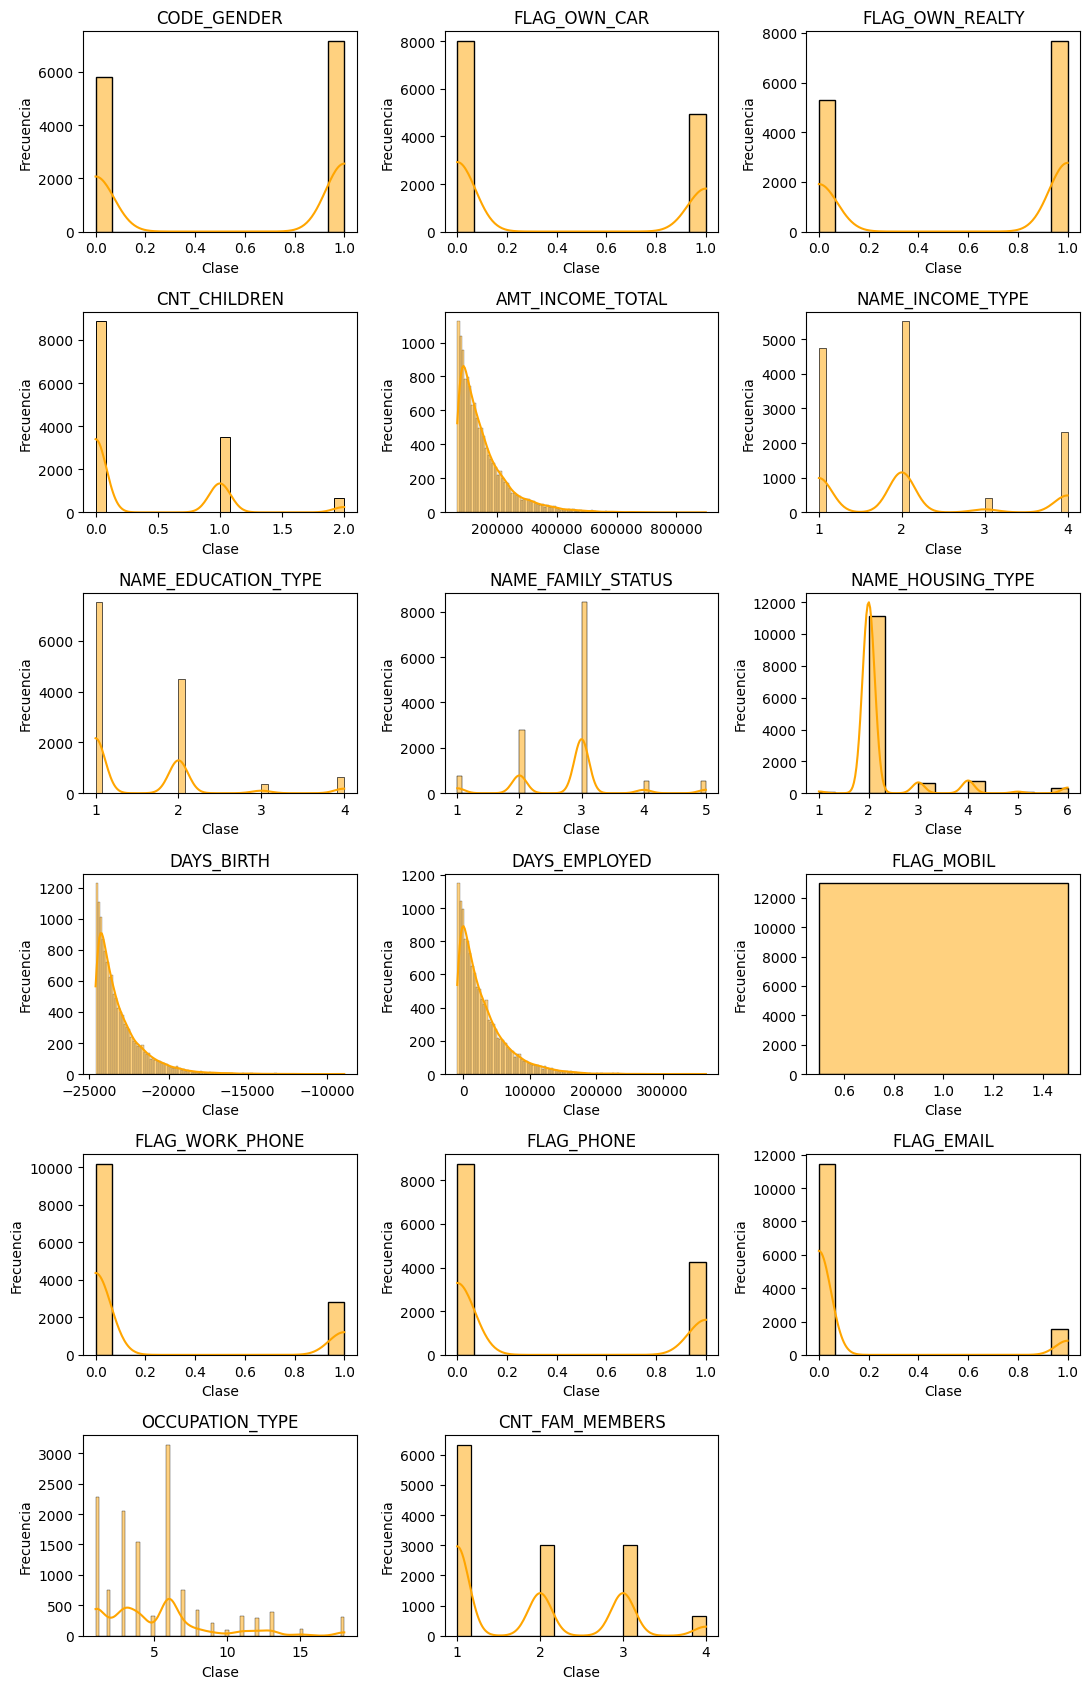

In [ ]:
columnas = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
            'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
            'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
            'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']

# Configuración de subplots (6 filas y 3 columnas)
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(11, 17))
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# Generar las gráficas
for i, col in enumerate(columnas):
    ax = axes[i]  # Seleccionar el eje correspondiente
    #datamin[col].value_counts().plot(kind='hist', ax=ax, color='skyblue')
    sns.histplot(synthetic_data[col], kde=True, ax=ax, color="orange")
    ax.set_title(col)
    ax.set_xlabel('Clase')
    ax.set_ylabel('Frecuencia')

# Eliminar los ejes vacíos (si no hay 18 columnas)
for j in range(len(columnas), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño
plt.tight_layout()
plt.show()


In [ ]:
datamin2 = data4[data4["Label"]==3]
datamin2

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Label
11,5112956,0,1,1,0,270000.0,1,1,2,2,-16872,-769,1,1,1,1,5,2.0,3
23,5008834,1,0,1,1,112500.0,1,2,3,2,-10968,-1620,1,0,0,0,6,2.0,3
29,5008840,0,0,1,1,405000.0,2,1,2,2,-11842,-2016,1,0,0,0,1,3.0,3
60,5008874,1,0,1,2,126000.0,2,1,2,2,-12411,-1773,1,0,0,1,1,4.0,3
61,5008875,1,0,1,2,126000.0,2,1,2,2,-12411,-1773,1,0,0,1,1,4.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36399,5125816,1,1,0,0,450000.0,3,1,2,2,-19783,-5521,1,1,1,0,1,2.0,3
36406,5126209,0,1,0,0,162000.0,3,1,2,2,-20053,365243,1,0,0,0,1,2.0,3
36410,5135485,1,0,1,0,135000.0,4,1,3,3,-10660,-1935,1,0,0,0,4,1.0,3
36423,5142964,0,0,0,1,180000.0,1,2,2,2,-10656,-926,1,1,1,0,6,3.0,3


### Gráficas de la clase minoritaria 3

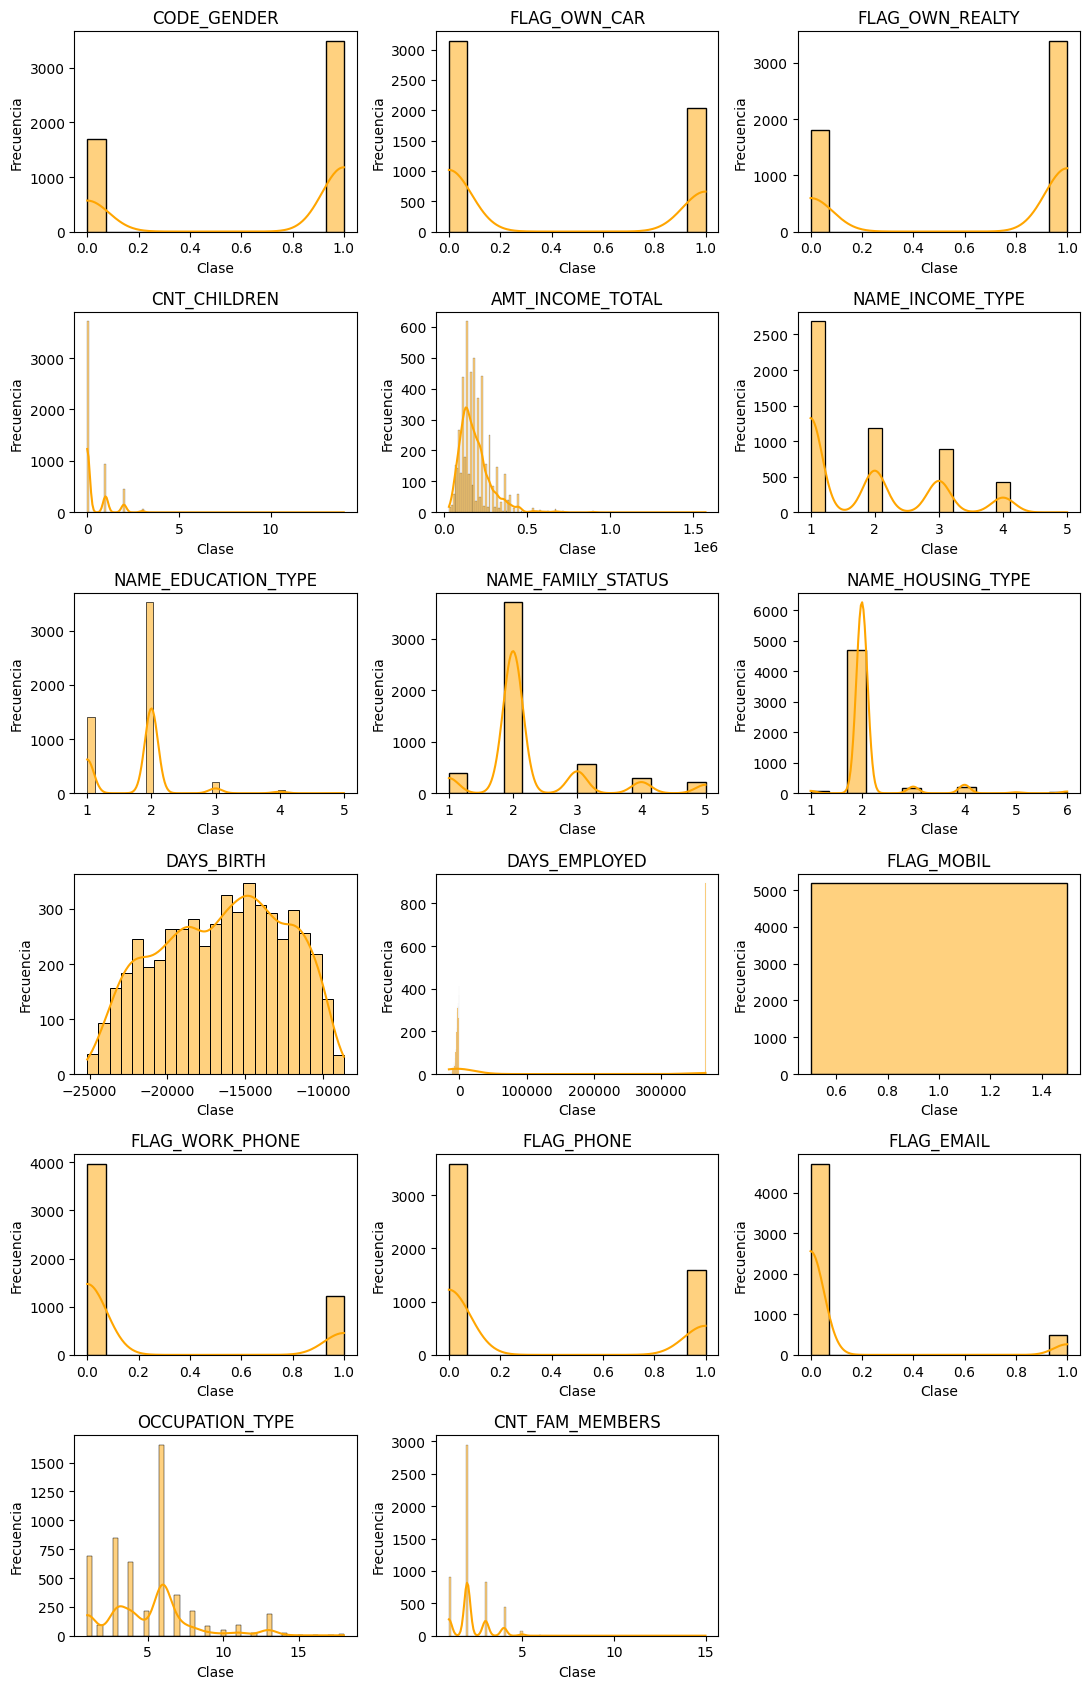

In [ ]:
# Lista de columnas a graficar (excluyendo 'ID' porque no tiene sentido para frecuencias)
columnas = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
            'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
            'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
            'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']

# Configuración de subplots (6 filas y 3 columnas)
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(11, 17))
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# Generar las gráficas
for i, col in enumerate(columnas):
    ax = axes[i]
    sns.histplot(datamin2[col], kde=True, ax=ax, color="orange")
    ax.set_title(col)
    ax.set_xlabel('Clase')
    ax.set_ylabel('Frecuencia')

# Eliminar los ejes vacíos (si no hay 18 columnas)
for j in range(len(columnas), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import truncnorm
def generate_synthetic_data_label_3(original_data, n_samples=7000):
    synthetic_data = pd.DataFrame()

    for column in original_data.columns:

        if column =="ID":
            last_id = original_data['ID'].max()
            new_ids = np.arange(last_id + 1, last_id + 1 + n_samples)
            synthetic_data[column] = new_ids
        elif original_data[column].nunique() < 10:
            synthetic_data[column] = np.random.choice(
                original_data[column].unique(),
                size=n_samples,
                p=original_data[column].value_counts(normalize=True).values
            )
        elif column =="OCCUPATION_TYPE":
            category_counts = original_data['OCCUPATION_TYPE'].value_counts()
            categories = category_counts.index
            probabilities = category_counts / category_counts.sum()

            synthetic_data['OCCUPATION_TYPE'] = np.random.choice(
                categories, size=n_samples, p=probabilities
            )
        else:
            mean = original_data[column].mean()
            std = original_data[column].std()
            min_val = original_data[column].min()
            max_val = original_data[column].max()
            if column == "DAYS_BIRTH":
                a, b = (min_val - mean) / std, (max_val - mean) / std
                synthetic_column = truncnorm.rvs(a, b, loc=mean, scale=std, size=n_samples)
                synthetic_data[column] = np.round(synthetic_column).astype(int)

            elif ("DAYS" in column and column != "DAYS_BIRTH") or column == "AMT_INCOME_TOTAL" :
                min_val = original_data[column].min()
                shifted_data = original_data[column] - min_val + 1

                mean = shifted_data.mean()
                scale = 1 / mean if mean > 0 else 1

                synthetic_column = np.random.exponential(scale=scale, size=n_samples)

                synthetic_column = synthetic_column / synthetic_column.max() * (shifted_data.max() - shifted_data.min())

                synthetic_data[column] = synthetic_column + min_val - 1
                synthetic_data[column] = np.round(synthetic_data[column]).astype(int)

    return synthetic_data

In [ ]:
synthetic_data_label_3= generate_synthetic_data_label_3(datamin2)

### Gráficas para visualizar los datos sintéticos 3.

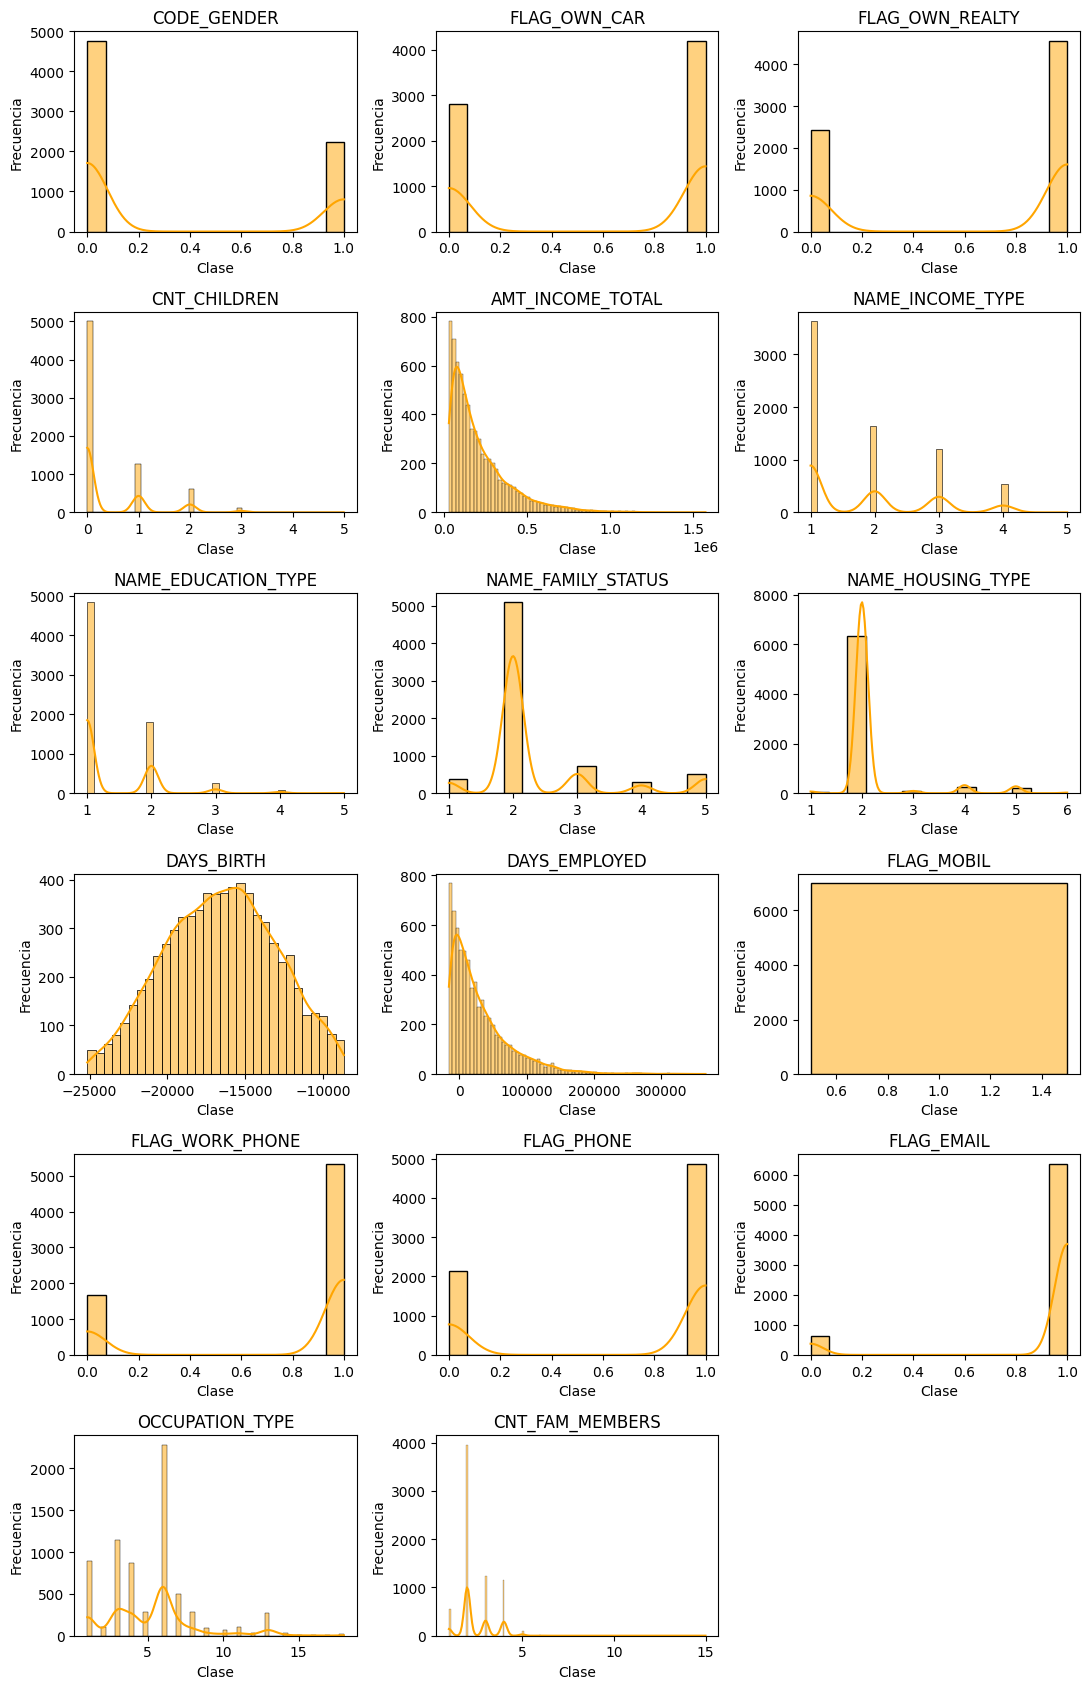

In [ ]:
columnas = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
            'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
            'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
            'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']

# Configuración de subplots (6 filas y 3 columnas)
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(11, 17))
axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# Generar las gráficas
for i, col in enumerate(columnas):
    ax = axes[i]  # Seleccionar el eje correspondiente
    #datamin[col].value_counts().plot(kind='hist', ax=ax, color='skyblue')
    sns.histplot(synthetic_data_label_3[col], kde=True, ax=ax, color="orange")
    ax.set_title(col)
    ax.set_xlabel('Clase')
    ax.set_ylabel('Frecuencia')

# Eliminar los ejes vacíos (si no hay 18 columnas)
for j in range(len(columnas), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño
plt.tight_layout()
plt.show()


In [ ]:
synthetic_data= pd.concat([synthetic_data, synthetic_data_label_3],axis= 0, ignore_index=True)

In [ ]:
synthetic_data.shape

(20000, 19)

### Merge con los datos sintéticos

Unimos el frame de los datos nuevos con el que ya teníamos y verificamos su forma.

In [ ]:
data_clean = pd.concat([data4, synthetic_data], axis=0, ignore_index=True)

In [ ]:
data_clean.shape

(56457, 19)

In [ ]:
data_clean

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Label
0,5008804,0,1,1,0,427500.0,1,1,1,1,-12005,-4542,1,1,0,0,1,2.0,1
1,5008805,0,1,1,0,427500.0,1,1,1,1,-12005,-4542,1,1,0,0,1,2.0,1
2,5008806,0,1,1,0,112500.0,1,2,2,2,-21474,-1134,1,0,0,0,2,2.0,2
3,5008808,1,0,1,0,270000.0,2,2,3,2,-19110,-3051,1,0,1,1,3,1.0,1
4,5008809,1,0,1,0,270000.0,2,2,3,2,-19110,-3051,1,0,1,1,3,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56452,5157477,0,1,0,1,43058.0,2,1,2,2,-21456,13294,1,1,1,1,6,2.0,3
56453,5157478,1,0,0,0,411112.0,1,3,2,2,-15659,7709,1,1,1,1,3,3.0,3
56454,5157479,1,0,1,0,267302.0,1,1,2,3,-21779,12790,1,1,1,1,6,1.0,3
56455,5157480,0,1,0,0,222158.0,1,1,2,2,-12442,14369,1,1,1,1,4,3.0,3


C:\Users\ramir\AppData\Local\Temp\ipykernel_17716\2682275552.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo.index, y=conteo.values, palette="muted")


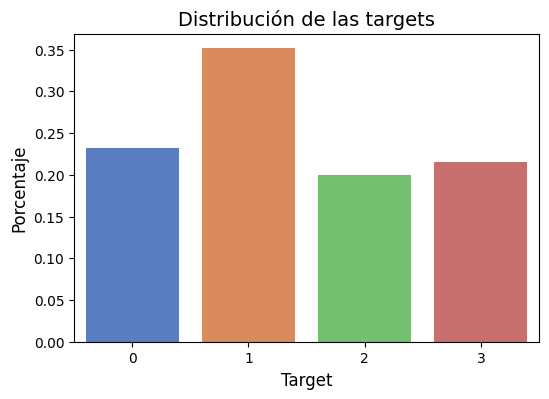

In [ ]:
conteo = data_clean['Label'].value_counts() / data_clean.shape[0]

plt.figure(figsize=(6,4))
sns.barplot(x=conteo.index, y=conteo.values, palette="muted")

plt.title('Distribución de las targets', fontsize=14)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Porcentaje', fontsize=12)

plt.show()

## Outliers
Analizamos los outliers mediante el calculo de IQR

In [ ]:
def detectar_outliers_iqr(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    return outliers
for col in data_clean.columns:
    outliers_col1 = detectar_outliers_iqr(data_clean, col)
    print(outliers_col1)

Empty DataFrame
Columns: [ID, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, DAYS_BIRTH, DAYS_EMPLOYED, FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, Label]
Index: []
Empty DataFrame
Columns: [ID, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, DAYS_BIRTH, DAYS_EMPLOYED, FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, Label]
Index: []
Empty DataFrame
Columns: [ID, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, DAYS_BIRTH, DAYS_EMPLOYED, FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, Label]
Index: []
Empty DataFrame
Columns: [ID, CODE_GENDER, FLAG_OWN_CAR

Calculo de valores atípicos con boxplots

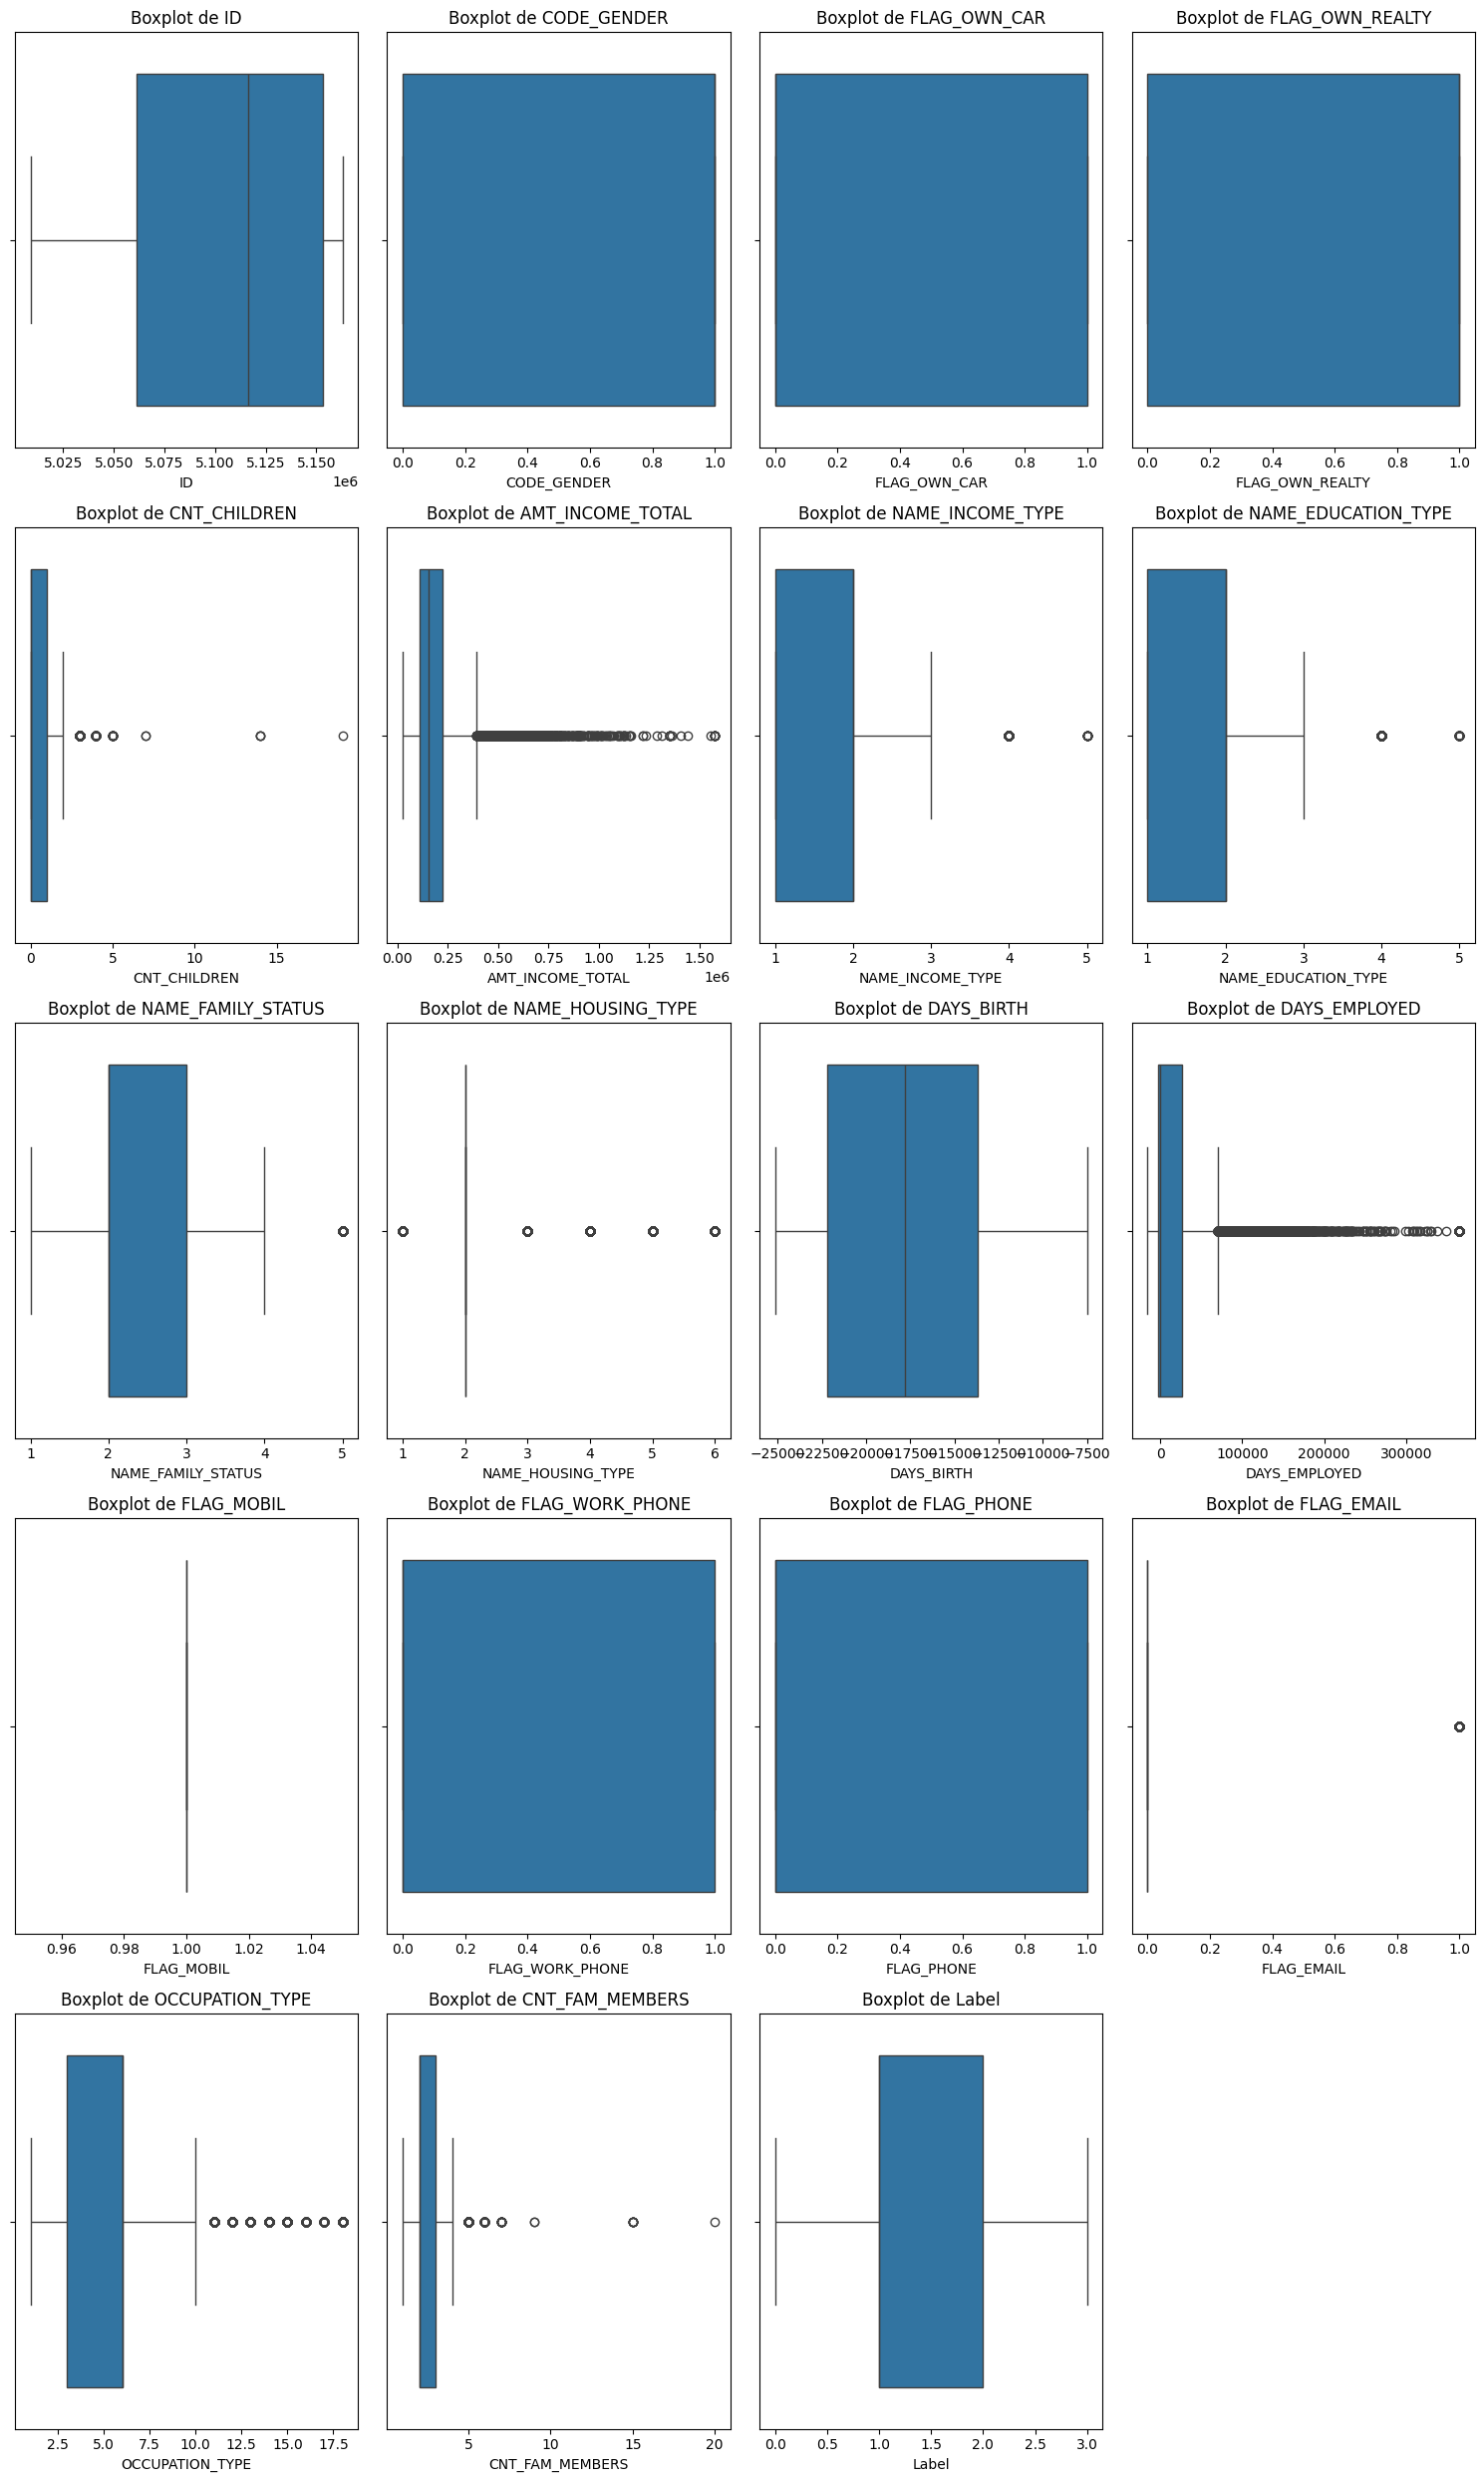

In [ ]:
import math
numero_columnas = len(data_clean.columns)

columnas_por_fila = 4
numero_filas = math.ceil(numero_columnas / columnas_por_fila)

# Crear subplots
fig, axes = plt.subplots(numero_filas, columnas_por_fila, figsize=(15, numero_filas * 5))  # Ajustar el tamaño del gráfico

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Graficar cada columna
for i, col in enumerate(data_clean.columns):
    sns.boxplot(data=data_clean, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')

# Ocultar ejes vacíos (si hay más subplots que columnas)
for i in range(len(data_clean.columns), len(axes)):
    axes[i].axis('off')

# Ajustar diseño
plt.tight_layout()
plt.show()

Procedemos a reemplazarlos mediante la tecnica de Winsorization ya que la cantidad de valores atípicos es grande y no podemos simplemente eliminarlos

In [ ]:
from scipy.stats.mstats import winsorize
def winzorizacion(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    porcentaje_inferior = (df[col] < limite_inferior).mean()
    porcentaje_superior = (df[col] > limite_superior).mean()
    df[col] = winsorize(df[col], limits=(porcentaje_inferior, porcentaje_superior))

In [ ]:
for col in data_clean.columns:
    winzorizacion(data_clean, col)

Graficamos para verificar que los outliers hayan sido tratados correctamente

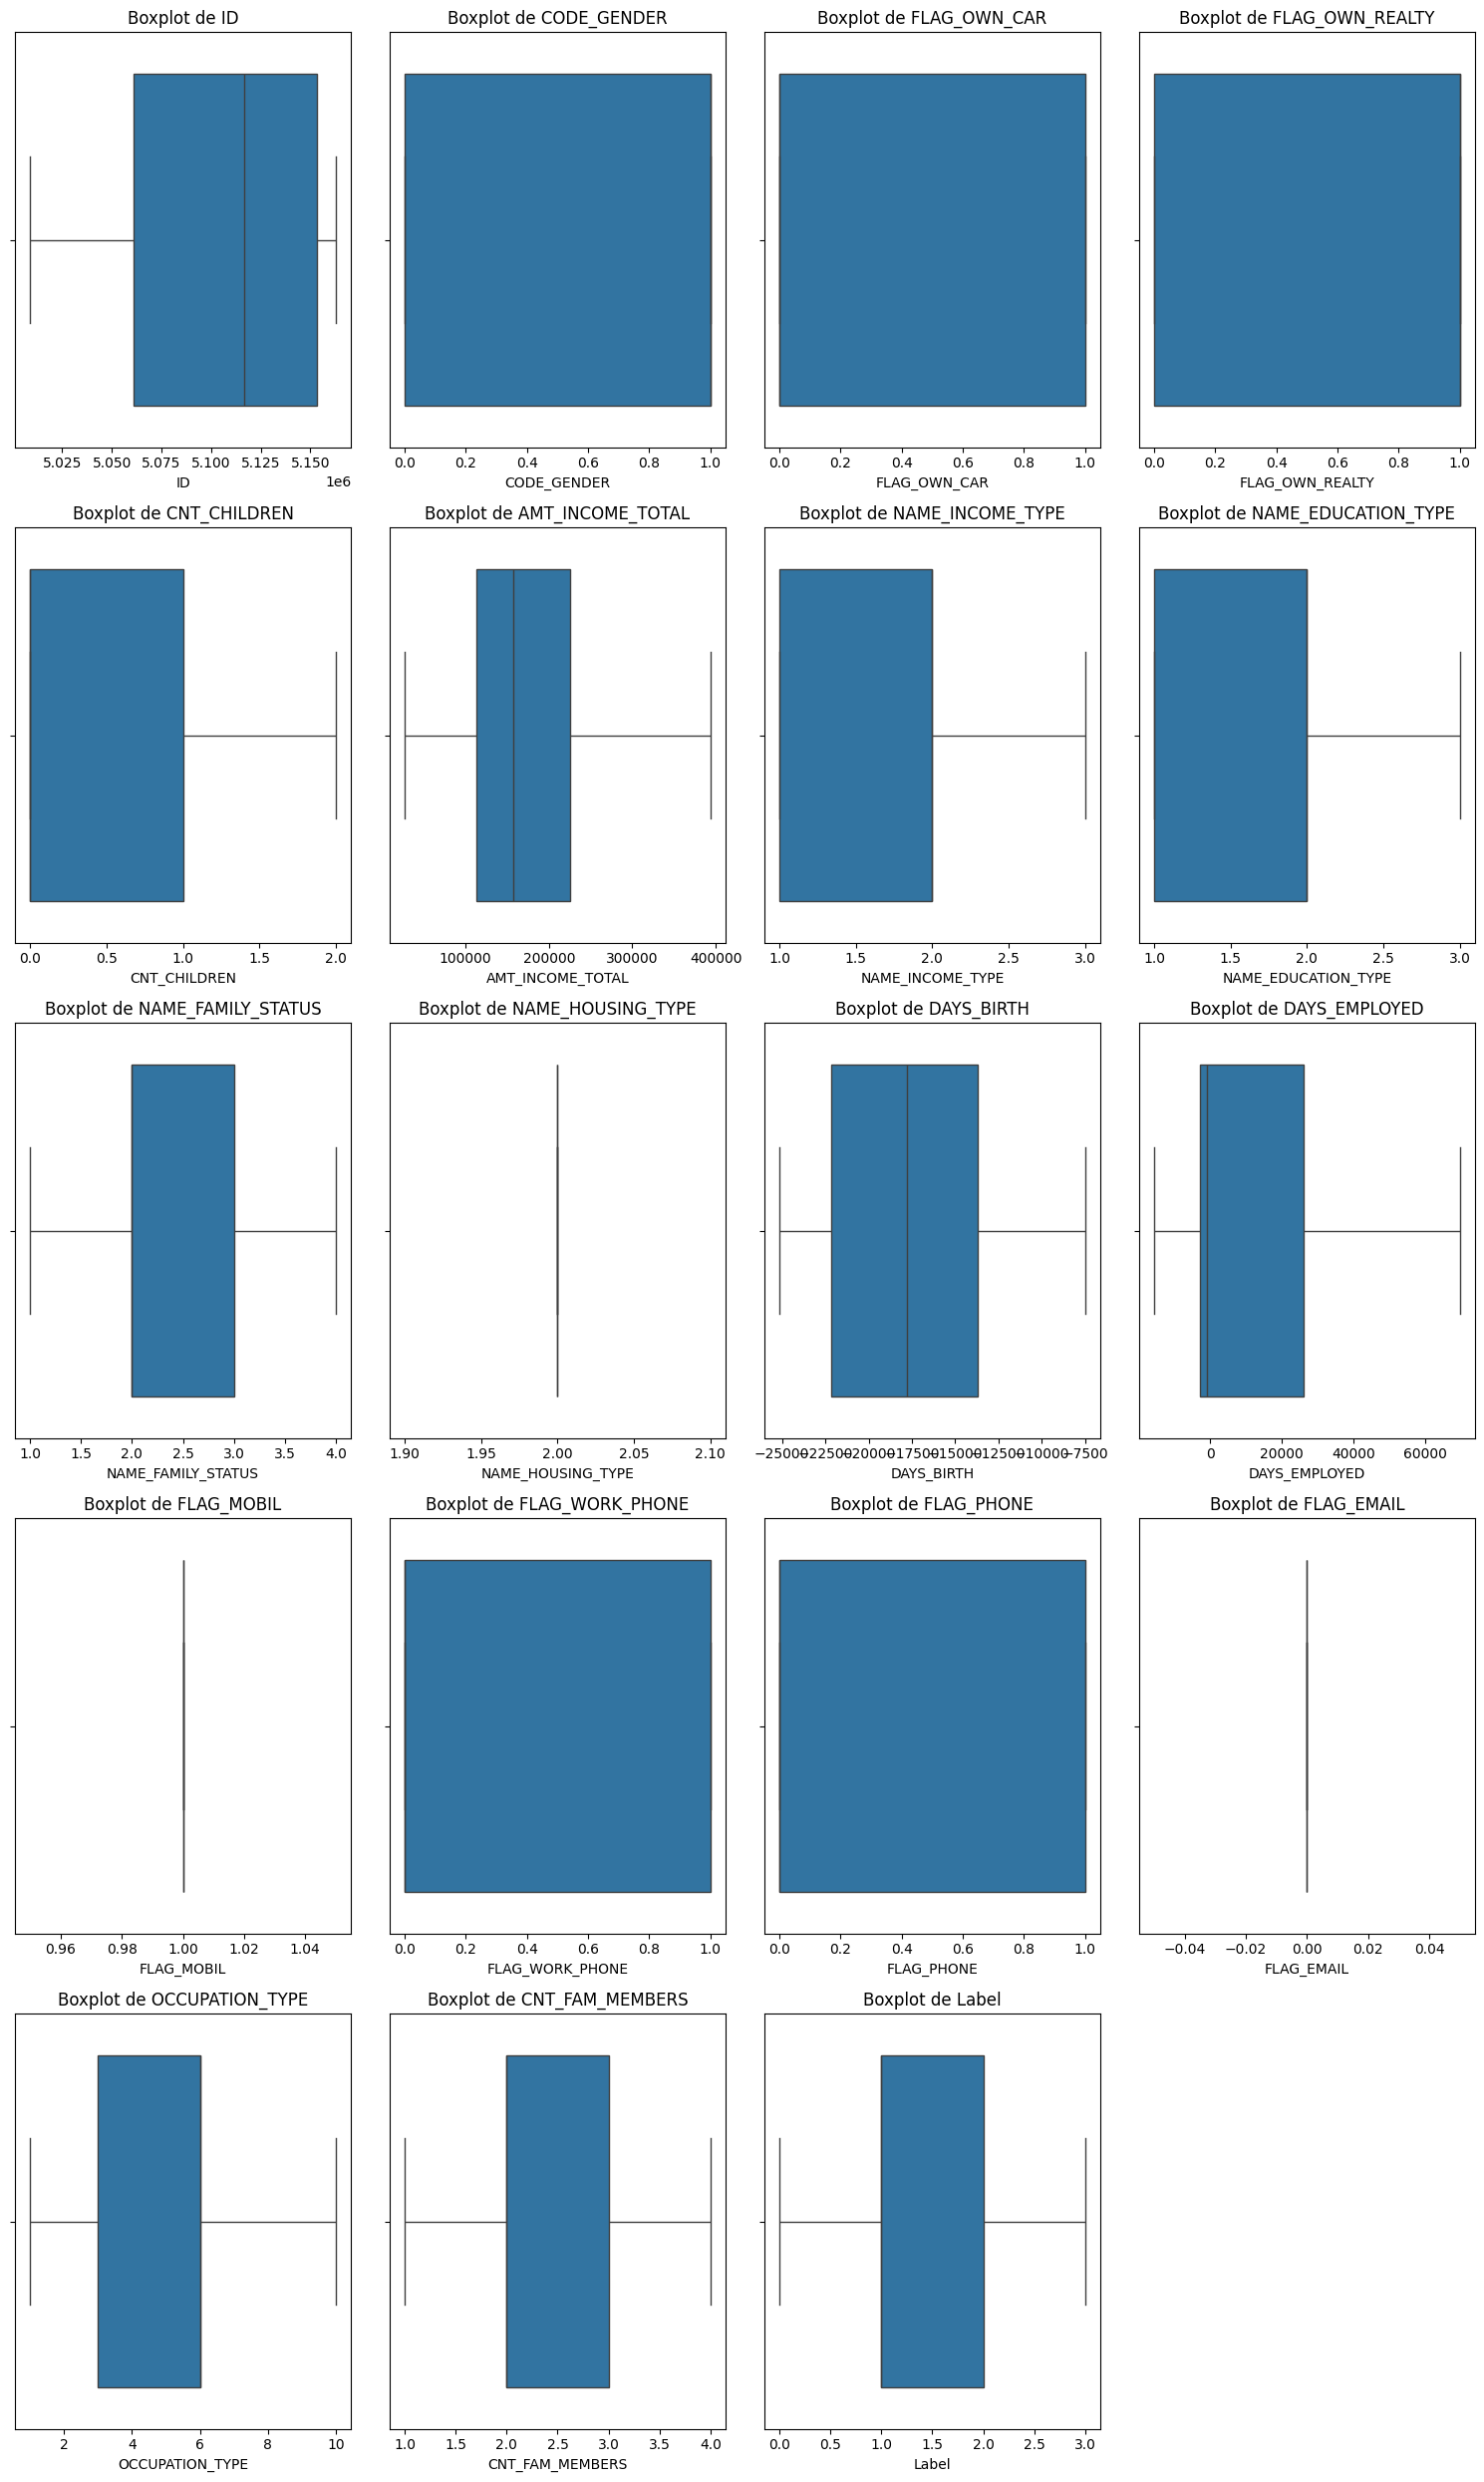

In [ ]:
import math
numero_columnas = len(data_clean.columns)

columnas_por_fila = 4
numero_filas = math.ceil(numero_columnas / columnas_por_fila)

# Crear subplots
fig, axes = plt.subplots(numero_filas, columnas_por_fila, figsize=(15, numero_filas * 5))  # Ajustar el tamaño del gráfico

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Graficar cada columna
for i, col in enumerate(data_clean.columns):
    sns.boxplot(data=data_clean, x=col, ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')

# Ocultar ejes vacíos (si hay más subplots que columnas)
for i in range(len(data_clean.columns), len(axes)):
    axes[i].axis('off')

# Ajustar diseño
plt.tight_layout()
plt.show()

## Validacion y Normalización de Datos

Validamos los datos usando dos técnicas diferentes para poder probar dos resultados distintos durante los experimentos y no limitarnos a un solo enfoque.

### Hold Out Estratificado

In [ ]:
# Usando Hold Out Estratificado 70

from sklearn.model_selection import train_test_split

# Separar las características (X) y el target (y)
X = data_clean.drop(columns=['Label'])  # Eliminar la columna de la etiqueta del dataset
y = data_clean['Label']                # Seleccionar la columna de la etiqueta

# Dividir los datos en entrenamiento y prueba usando stratify para mantener la proporción de clases
X_train_holdOut, X_test_holdOut, y_train_holdOut, y_test_holdOut = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=12
)

# Verificar la proporción de clases en el dataset original, entrenamiento y prueba
print("Proporción de clases en el dataset original:")
print(y.value_counts(normalize=True))

print("\nProporción de clases en el conjunto de entrenamiento:")
print(y_train_holdOut.value_counts(normalize=True))

print("\nProporción de clases en el conjunto de prueba:")
print(y_test_holdOut.value_counts(normalize=True))

Proporción de clases en el dataset original:
Label
1    0.351453
0    0.232442
3    0.215899
2    0.200205
Name: proportion, dtype: float64

Proporción de clases en el conjunto de entrenamiento:
Label
1    0.351451
0    0.232445
3    0.215896
2    0.200207
Name: proportion, dtype: float64

Proporción de clases en el conjunto de prueba:
Label
1    0.351458
0    0.232436
3    0.215905
2    0.200201
Name: proportion, dtype: float64


### K-Fold (5 folds)

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Configuración de K-Folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Crear listas para almacenar los conjuntos de datos de cada pliegue
folds_data = []

X_train_dataset = data_clean.drop(columns=['Label'])
y_train_dataset = data_clean['Label']

# Realizar la división de los datos
for train_index, test_index in kf.split(X_train_dataset, y_train_dataset):
    # Dividir los datos en entrenamiento y prueba
    X_train_kfold, X_test_kfold = X_train_dataset.iloc[train_index], X_train_dataset.iloc[test_index]
    y_train_kfold, y_test_kfold = y_train_dataset.iloc[train_index], y_train_dataset.iloc[test_index]

    # Guardar en una lista para usarlos después
    folds_data.append((X_train_kfold, X_test_kfold, y_train_kfold, y_test_kfold))

### Normalización

Normalizamos los datos para mejorar los resultados en los algoritmos.

Hold Out Estratificado

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_holdOut = scaler.fit_transform(X_train_holdOut)
X_test_holdOut = scaler.transform(X_test_holdOut)
print("Normalized input data(X):\n", X_train_holdOut)

Normalized input data(X):
 [[-1.59486392 -1.22091808  1.20650899 ...  0.          0.39769153
  -0.15595361]
 [ 0.94368114  0.81905577 -0.82883758 ...  0.         -1.54370376
  -1.26803059]
 [ 0.89605781 -1.22091808  1.20650899 ...  0.          0.39769153
   2.06820036]
 ...
 [-0.73844345 -1.22091808  1.20650899 ...  0.          0.39769153
   0.95612337]
 [-1.38318693  0.81905577 -0.82883758 ...  0.         -1.54370376
  -1.26803059]
 [ 0.74027778  0.81905577 -0.82883758 ...  0.          0.00941247
   2.06820036]]


K-Fold

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_kfold = scaler.fit_transform(X_train_kfold)
X_test_kfold = scaler.transform(X_test_kfold)
print("Normalized input data(X):\n", X_train_kfold)

Normalized input data(X):
 [[-1.93466713 -1.22009096  1.20455146 ...  0.         -1.5495977
  -0.15427045]
 [-1.93458714  0.81961102 -0.83018454 ...  0.         -0.77013929
  -1.26768997]
 [-1.93452716  0.81961102 -0.83018454 ...  0.         -0.77013929
  -1.26768997]
 ...
 [ 1.0382689   0.81961102 -0.83018454 ...  0.         -0.77013929
   0.95914906]
 [ 1.03828889  0.81961102 -0.83018454 ...  0.          0.39904833
  -1.26768997]
 [ 1.03830889 -1.22009096  1.20455146 ...  0.         -0.38041008
   0.95914906]]


# ALGORITMOS DE CLASIFICACIÓN

Se han seleccionado 3 algoritmos de clasificación:

* Random Forest Classifier
* Gradient Boosting Classifier
* Decision Tree Classifier
* Support Vector Machine

Todos se probarán con las dos técnicas de validación para comprobar resultados.

### Random Forest Classifier



Usando validacion Hold Out

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Crear y entrenar el modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_kfold, y_train_kfold)

# Realizar predicciones
rf_predictions = rf_model.predict(X_test_kfold)

# Evaluar el modelo
print("Matriz de Confusión - Random Forest:")
print(confusion_matrix(y_test_kfold, rf_predictions))
print("\nReporte de Clasificación - Random Forest:")
print(classification_report(y_test_kfold, rf_predictions))


Matriz de Confusión - Random Forest:
[[2553   13    3   56]
 [   8 2961  734  265]
 [   4  928 1037  292]
 [  67  367  308 1695]]

Reporte de Clasificación - Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2625
           1       0.69      0.75      0.72      3968
           2       0.50      0.46      0.48      2261
           3       0.73      0.70      0.71      2437

    accuracy                           0.73     11291
   macro avg       0.72      0.72      0.72     11291
weighted avg       0.73      0.73      0.73     11291



Usando validación K-Fold

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Inicializar el modelo Random Forest
rf_model = RandomForestClassifier(class_weight='balanced',random_state=42, n_estimators=100)

# Entrenar y evaluar en cada pliegue
for i, (X_train_kfold, X_test_kfold, y_train_kfold, y_test_kfold) in enumerate(folds_data):
    print(f"\nEntrenando el pliegue {i + 1} con Random Forest...")

    # Entrenar el modelo
    rf_model.fit(X_train_kfold, y_train_kfold)

    # Realizar predicciones
    y_pred_kfold = rf_model.predict(X_test_kfold)

    # Evaluar el modelo
    print(f"Reporte de clasificación para el pliegue {i + 1}:")
    print(classification_report(y_test_kfold, y_pred_kfold))



Entrenando el pliegue 1 con Random Forest...
Reporte de clasificación para el pliegue 1:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2624
           1       0.66      0.70      0.68      3369
           2       0.53      0.51      0.52      2261
           3       0.74      0.70      0.72      2438

    accuracy                           0.73     10692
   macro avg       0.73      0.72      0.72     10692
weighted avg       0.73      0.73      0.73     10692


Entrenando el pliegue 2 con Random Forest...
Reporte de clasificación para el pliegue 2:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2624
           1       0.67      0.71      0.69      3369
           2       0.52      0.51      0.51      2261
           3       0.74      0.68      0.71      2438

    accuracy                           0.73     10692
   macro avg       0.72      0.72      0.72     10692
weigh

### Gradient Boosting Classifier (XGBoost)

Usando validación Hold Out

In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Crear un mapeo de las clases
unique_classes = np.unique(y_train_holdOut)
class_mapping = {val: idx for idx, val in enumerate(unique_classes)}
inverse_class_mapping = {idx: val for val, idx in class_mapping.items()}

# Mapear las clases en y_train_holdOut y y_test_holdOut
y_train_mapped = y_train_holdOut.map(class_mapping)
y_test_mapped = y_test_holdOut.map(class_mapping)

# Crear y entrenar el modelo de XGBoost
xgb_model = XGBClassifier(scale_pos_weight=60, random_state=42, n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train_holdOut, y_train_mapped)

# Realizar predicciones
xgb_predictions_mapped = xgb_model.predict(X_test_holdOut)

# Revertir el mapeo para interpretar las predicciones
xgb_predictions = pd.Series(xgb_predictions_mapped).map(inverse_class_mapping)

# Evaluar el modelo
print("Matriz de Confusión - XGBoost:")
print(confusion_matrix(y_test_holdOut, xgb_predictions))
print("\nReporte de Clasificación - XGBoost:")
print(classification_report(y_test_holdOut, xgb_predictions))


c:\Users\ramir\OneDrive\Documentos\ESCOM\Tercer_Semestre\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:39:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Matriz de Confusión - XGBoost:
[[3812   40    9   76]
 [   9 4509  524   11]
 [   3 2609  767   12]
 [  91 1222  333 2011]]

Reporte de Clasificación - XGBoost:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3937
           1       0.54      0.89      0.67      5053
           2       0.47      0.23      0.31      3391
           3       0.95      0.55      0.70      3657

    accuracy                           0.69     16038
   macro avg       0.73      0.66      0.66     16038
weighted avg       0.73      0.69      0.67     16038



Usando validación K-Fold

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Inicializar el modelo Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1)

# Entrenar y evaluar en cada pliegue
for i, (X_train_kfold, X_test_kfold, y_train_kfold, y_test_kfold) in enumerate(folds_data):
    print(f"\nEntrenando el pliegue {i + 1} con Gradient Boosting...")

    # Entrenar el modelo
    gb_model.fit(X_train_kfold, y_train_kfold)

    # Realizar predicciones
    y_pred_kfold = gb_model.predict(X_test_kfold)

    # Evaluar el modelo
    print(f"Reporte de clasificación para el pliegue {i + 1}:")
    print(classification_report(y_test_kfold, y_pred_kfold))



Entrenando el pliegue 1 con Gradient Boosting...
Reporte de clasificación para el pliegue 1:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2625
           1       0.55      0.99      0.71      3969
           2       0.44      0.02      0.05      2260
           3       0.96      0.56      0.70      2438

    accuracy                           0.70     11292
   macro avg       0.73      0.63      0.61     11292
weighted avg       0.72      0.70      0.64     11292


Entrenando el pliegue 2 con Gradient Boosting...
Reporte de clasificación para el pliegue 2:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2625
           1       0.55      0.98      0.70      3969
           2       0.41      0.03      0.06      2260
           3       0.96      0.55      0.70      2438

    accuracy                           0.70     11292
   macro avg       0.72      0.63      0.61     112

### Decision Tree

Usando validación Hold Out

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

clf = DecisionTreeClassifier(random_state=42)

clf.fit(X_train_holdOut, y_train_holdOut)
clf_predictions = clf.predict(X_test_holdOut)

# Evaluar el modelo
print("Matriz de Confusión - XGBoost:")
print(confusion_matrix(y_test_holdOut, clf_predictions))
print("\nReporte de Clasificación - XGBoost:")
print(classification_report(y_test_holdOut, clf_predictions))


Matriz de Confusión - XGBoost:
[[3745   19   13  160]
 [  24 4058 1337  534]
 [  12 1222 1680  477]
 [ 137  516  471 2533]]

Reporte de Clasificación - XGBoost:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3937
           1       0.70      0.68      0.69      5953
           2       0.48      0.50      0.49      3391
           3       0.68      0.69      0.69      3657

    accuracy                           0.71     16938
   macro avg       0.70      0.71      0.70     16938
weighted avg       0.71      0.71      0.71     16938



Usando validación K-Fold

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

clf = DecisionTreeClassifier(random_state=42)

# Entrenar y evaluar en cada pliegue
for i, (X_train_kfold, X_test_kfold, y_train_kfold, y_test_kfold) in enumerate(folds_data):
    print(f"\nEntrenando el pliegue {i + 1} con Gradient Boosting...")

    # Entrenar el modelo
    clf.fit(X_train_kfold, y_train_kfold)

    # Realizar predicciones
    clf_predictions = clf.predict(X_test_kfold)

    # Evaluar el modelo
    print(f"Reporte de clasificación para el pliegue {i + 1}:")
    print(classification_report(y_test_kfold, clf_predictions))


Entrenando el pliegue 1 con Gradient Boosting...
Reporte de clasificación para el pliegue 1:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2625
           1       0.71      0.70      0.71      3969
           2       0.48      0.50      0.49      2260
           3       0.70      0.68      0.69      2438

    accuracy                           0.72     11292
   macro avg       0.71      0.71      0.71     11292
weighted avg       0.72      0.72      0.72     11292


Entrenando el pliegue 2 con Gradient Boosting...
Reporte de clasificación para el pliegue 2:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2625
           1       0.71      0.69      0.70      3969
           2       0.48      0.50      0.49      2260
           3       0.68      0.68      0.68      2438

    accuracy                           0.71     11292
   macro avg       0.70      0.71      0.71     112

### Support Vector Machine

Usando validación Hold Out

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# CrEar el modelo
svm_model = SVC(kernel='linear', random_state=42)

# Entrenar el modelo
svm_model.fit(X_train_holdOut, y_train_holdOut)

# Predecir los valores en el conjunto de prueba
y_pred = svm_model.predict(X_test_holdOut)

# Evaluar el modelo
accuracy = accuracy_score(y_test_holdOut, y_pred)
print(f"Accuracy del modelo: {accuracy:.2f}")

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test_holdOut, y_pred))


KeyboardInterrupt: 

... se tarda mucho :(